# Having a look at the EUREC4A region in the ICON-1km AMIP +4K runs


In [1]:
import intake
import easygems.healpix

cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
data = cat.ICON.C5['AMIP_CNTL'].to_dask()
data = easygems.healpix.attach_coords(data, signed_lon=True)
data

<xarray.Dataset>
Dimensions:             (cell: 786432, time: 5478, level_full: 26,
                         level_half: 26)
Coordinates:
  * time                (time) datetime64[ns] 1979-01-02 ... 1993-12-31
  * level_full          (level_full) float64 14.0 21.0 25.0 ... 87.0 89.0 90.0
  * level_half          (level_half) float64 14.0 21.0 25.0 ... 87.0 89.0 90.0
    crs                 int64 0
    lat                 (cell) float64 0.1492 0.2984 0.2984 ... -0.2984 -0.1492
    lon                 (cell) float64 45.0 45.18 44.82 ... -44.82 -45.18 -45.0
Dimensions without coordinates: cell
Data variables: (12/44)
    cell_elevation      (cell) float64 dask.array<chunksize=(786432,), meta=np.ndarray>
    cell_sea_land_mask  (cell) int32 dask.array<chunksize=(786432,), meta=np.ndarray>
    clivi               (time, cell) float32 dask.array<chunksize=(364, 786432), meta=np.ndarray>
    cllvi               (time, cell) float32 dask.array<chunksize=(364, 786432), meta=np.ndarray>
    hus2m               (time, cell) float32 dask.array<chunksize=(364, 786432), meta=np.ndarray>
    hfls                (time, cell) float32 dask.array<chunksize=(364, 786432), meta=np.ndarray>
    ...                  ...
    qg                  (time, level_full, cell) float32 dask.array<chunksize=(364, 26, 786432), meta=np.ndarray>
    qr                  (time, level_full, cell) float32 dask.array<chunksize=(364, 26, 786432), meta=np.ndarray>
    qs                  (time, level_full, cell) float32 dask.array<chunksize=(364, 26, 786432), meta=np.ndarray>
    ta                  (time, level_full, cell) float32 dask.array<chunksize=(364, 26, 786432), meta=np.ndarray>
    pfull               (time, level_full, cell) float32 dask.array<chunksize=(364, 26, 786432), meta=np.ndarray>
    phalf               (time, level_half, cell) float32 dask.array<chunksize=(364, 26, 786432), meta=np.ndarray>
Attributes:
    history:  Wed May 15 09:39:51 2024: ncatted -O -a ,global,d,, independent...
    NCO:      netCDF Operators version 5.0.6 (Homepage = http://nco.sf.net, C...

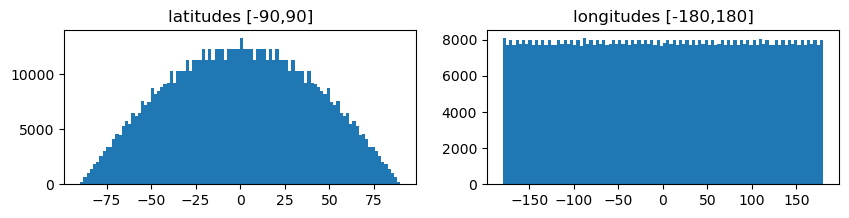

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def fig_latlon_histogram(data):
    fig, axs = plt.subplots(1,2, figsize=(10,2))
    axs[0].hist(data.lat.values, bins=100)
    axs[0].set_title(f'latitudes [{np.min(data.lat.values):.0f},{np.max(data.lat.values):.0f}]')
    axs[1].hist(data.lon.values, bins=100)
    axs[1].set_title(f'longitudes [{np.min(data.lon.values):.0f},{np.max(data.lon.values):.0f}]')
    return fig, axs

fig, axs = fig_latlon_histogram(data)
fig.show()

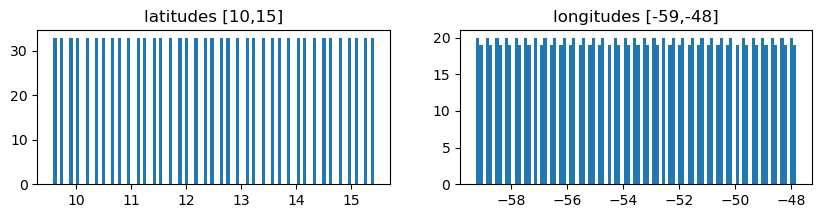

In [3]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)
import postprocessing as pp

fig, axs = fig_latlon_histogram(pp.cut_borders(data))
fig.show()

In [4]:
def select_february_data(dataset):
    february_mask = dataset.time.dt.month == 2
    return dataset.sel(time=february_mask)

select_february_data(data).time

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.DataArray 'time' (time: 424)>
array(['1979-02-01T00:00:00.000000000', '1979-02-02T00:00:00.000000000',
       '1979-02-03T00:00:00.000000000', ..., '1993-02-26T00:00:00.000000000',
       '1993-02-27T00:00:00.000000000', '1993-02-28T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-02-01 1979-02-02 ... 1993-02-28
    crs      int64 0
Attributes:
    standard_name:  time
    axis:           T

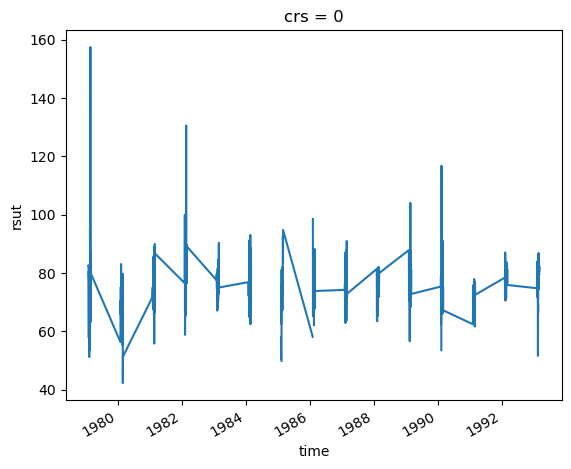

In [5]:
def find_var(data, keywords):
    variables = dict()
    for var in list(data):
        maybe = {var : data[var].attrs['long_name']}
        if all([keyword in maybe[var] for keyword in keywords]):
            variables.update(maybe)
    return variables

# def add_icecloud_mask(dataset):
#     return pp.add_threshold_indicator(dataset, variable_name='clivi', threshold=1e-4, new_variable_name='high_ice', long_name='ice cloud mask', boolean=True)

find_var(data, ['radiation', 'short'])
find_var(data, ['ice'])
# data['clivi']

d = pp.cut_borders(data)
d = select_february_data(d)
# # pp.add_threshold_indicator??
# # icefree = add_icecloud_mask(data)
# # icefree['high_ice'].plot()
d.where(d['clivi'] < 1e-4)['rsut'].mean(dim='cell').plot()#.drop_vars(['high_ice'])

# # print('filter for ice')
# # print('show shortwave')

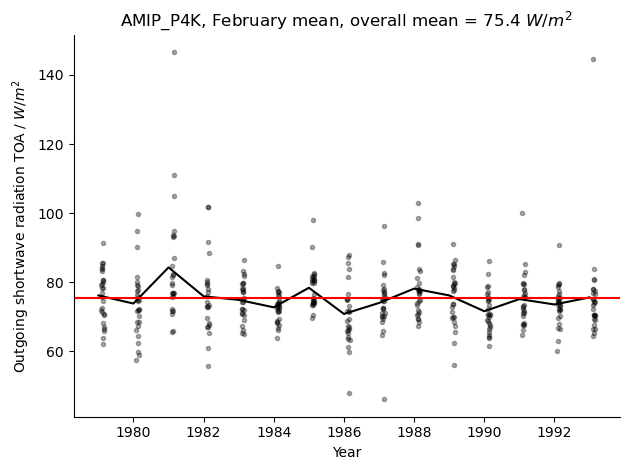

In [6]:
import sys
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)
import file_handling as fh

import intake
import easygems.healpix
import postprocessing as pp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plot_utils as pu

def get_amip_data(experiment='AMIP_P4K'): # ['AMIP_CNTL', 'AMIP_P4K']
    cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
    data = cat.ICON.C5[experiment].to_dask()
    data = easygems.healpix.attach_coords(data, signed_lon=True)
    data = pp.cut_borders(data)
    data = data.where(data['clivi'] < 1e-4)
    data = select_february_data(data)
    return data

def select_february_data(dataset):
    february_mask = dataset.time.dt.month == 2
    return dataset.sel(time=february_mask)

def ax_amip_feburary_timeseries(ax):
    experiment='AMIP_P4K'
    d = get_amip_data(experiment=experiment)
    d = d['rsut'].mean(dim='cell', keep_attrs=True)
    ax.scatter(d.time, d.values, marker='.', color='black', alpha=0.33)

    d = d.groupby('time.year').mean(dim='time', keep_attrs=True)
    ax.plot(pd.to_datetime(d.year.values, format="%Y"), d.values, color='black')
    ax.axhline(np.mean(d.values), color='red')
    ax = pu.remove_spines(ax, ['right','top'])

    ax.set_title(f'{experiment}, February mean, overall mean = {np.mean(d.values):.1f} $W/m^2$')
    ax.set_xlabel('Year')
    ax.set_ylabel('Outgoing shortwave radiation TOA / $W/m^2$')
    return ax

fig, ax = plt.subplots()
ax = ax_amip_feburary_timeseries(ax)
fig.tight_layout()
fig.show()

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/home/m/m300872/warm_eurec4a/submodules/file_handling.py:951: UserWarning: There might have been a problem with double output for some time steps. Data was loaded with `concat_dim='time'` and sorted via `dataset.sortby(dataset['time'])`. Check the time axis!
  if not supress_warning: warnings.warn(


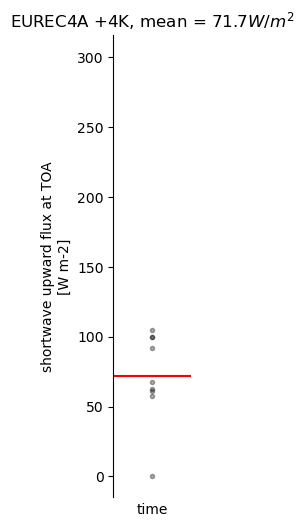

In [7]:
import matplotlib.pyplot as plt
import plot_utils as pu

def get_eureca_dommean():
    path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05'
    data = fh.disk_data_from_keywords(path, ['DOM01', 'domainmean'])
    return data

def ax_eureca_scatter(ax):
    data = get_eureca_dommean()
    var = 'sou_t'
    color = 'grey'
    data[var].sel({'quantile':-1}).plot(ax=ax, label='mean over domain', color=color, lw=0.3, alpha=.5)
    daily_averages = data.resample(time='D').mean(keep_attrs=True)
    daily_averages = daily_averages[var].sel({'quantile':-1}).values
    ax.scatter([1]*len(daily_averages), daily_averages, marker='.', color='black', alpha=0.33)
    ax.axhline(np.mean(daily_averages), color='red')
    ax = pu.remove_spines(ax, ['right','top', 'bottom'])
    ax = pu.remove_ticks(ax, ['top', 'bottom','right'])
    ax.set_xlim(0.9,1.1)
    ax.set_title(f'EUREC4A +4K, mean = {np.mean(daily_averages):.1f}$W/m^2$')

fig, ax  = plt.subplots(figsize=(1,6))
ax = ax_eureca_scatter(ax)
fig.show()

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/home/m/m300872/warm_eurec4a/submodules/file_handling.py:951: UserWarning: There might have been a problem with double output for some time steps. Data was loaded with `concat_dim='time'` and sorted via `dataset.sortby(dataset['time'])`. Check the time axis!
  if not supress_warning: warnings.warn(


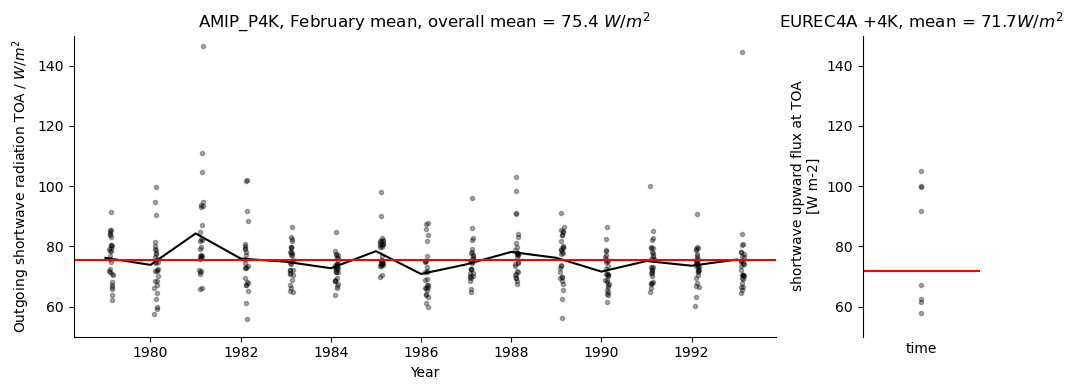

In [8]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[6, 1])
axs = list()
axs.append(fig.add_subplot(gs[0]))
axs[0].set_ylim(50, 150)
axs.append(fig.add_subplot(gs[1], sharey=axs[0]))
axs[1].set_xlim(0.8,1.2)
ax = ax_amip_feburary_timeseries(axs[0])
ax = ax_eureca_scatter(axs[1])

fig.tight_layout()
fig.show()